[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mlnoobs/mlops-project-study/blob/main/2022-05-30/training_remind_seminar.ipynb)

# 딥러닝 remind 세미나 1 - mnist inference

- Linear(Fully-Connected layer), CNN(Convolutional neural network) 훈련 및 인퍼런스를 PyTorch를 사용해 google colab GPU에서 시도합니다.

## 필요 툴&라이브러리 설치

In [1]:
!pip install --upgrade pip
!pip install torch
!pip install torchvision
!pip install numpy
!pip install matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 33.4 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## import & 버전 확인

In [3]:
!python --version
!nvidia-smi
import torch
import torch.nn.functional as F
import numpy as np
import torchvision
from matplotlib import pyplot as plt
import time
print(torch.__version__)
print(np.__version__)
print(torchvision.__version__)


Python 3.7.13
Tue Jun  7 12:54:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                          

## Hyperpatemerers 등 configs 세팅

In [4]:
# 훈련 결과 재현을 위한 seed값 고정
seed = '202205281708'
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-2
n_epochs = 10
batch_size = 512

print("device:", device)
print("- gpu를 사용할 수 있는 환경이면 \'cuda\', 그렇지 않으면 \'cpu\'를 사용합니다.")
print("lr:", lr)
print("- learning rate는 이번 훈련으로 얻어낸 gradients를 얼마만큼의 강도로 모델 업데이트에 반영할지를 결정합니다.")
print("n_epochs:", n_epochs)
print("- epoch의 횟수는 전체 데이터셋을 몇 번 반복해서 훈련할 것인지를 결정합니다.")
print("batch_size:", batch_size)
print("- 훈련 시 mini-batch의 사이즈를 결정합니다.")
print("- SGD(stochastic gradient descent) 기반의 optimizer를 사용한다면,")
print("- 전체 데이터셋을 자그마한 mini-batch로 나누어서 순차적으로 훈련에 사용하게 됩니다.")
print("- 보통 클수록 보다 성능을 높이는 방향으로 훈련될 가능성이 높지만 메모리를 많이 차지하게 됩니다.")

device: cuda
- gpu를 사용할 수 있는 환경이면 'cuda', 그렇지 않으면 'cpu'를 사용합니다.
lr: 0.01
- learning rate는 이번 훈련으로 얻어낸 gradients를 얼마만큼의 강도로 모델 업데이트에 반영할지를 결정합니다.
n_epochs: 10
- epoch의 횟수는 전체 데이터셋을 몇 번 반복해서 훈련할 것인지를 결정합니다.
batch_size: 512
- 훈련 시 mini-batch의 사이즈를 결정합니다.
- SGD(stochastic gradient descent) 기반의 optimizer를 사용한다면,
- 전체 데이터셋을 자그마한 mini-batch로 나누어서 순차적으로 훈련에 사용하게 됩니다.
- 보통 클수록 보다 성능을 높이는 방향으로 훈련될 가능성이 높지만 메모리를 많이 차지하게 됩니다.


## 공개 데이터셋 다운로드: MNIST
torchvision 라이브러리를 사용하면 공개 데이터셋을 편리하게 다운로드받고, torch tensor 자료형으로 불러올 수 있습니다.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_dataset/MNIST/raw

len(train_data): 60000
len(test_data): 10000
shape: torch.Size([1, 28, 28])
label: 3
maxval: tensor(2.8215)
minval: tensor(-0.4242)
mean of all training dataset: tensor(-0.0001)
var of all training dataset: tensor(1.0001)


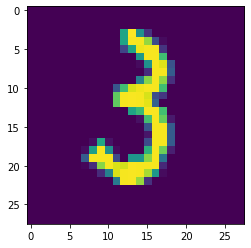

In [5]:
# torchvision 라이브러리를 사용해 MNIST 데이터셋 다운로드 및 전처리
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)) # MNIST 데이터셋의 평균과 표준편차
            ])
train_data = torchvision.datasets.MNIST('./mnist_dataset', train=True, download=True,
                            transform=transform)
test_data = torchvision.datasets.MNIST('./mnist_dataset', train=False, download=True,
                            transform=transform)
print('len(train_data):', len(train_data))
print('len(test_data):', len(test_data))

# 데이터 정보를 확인해봅시다.
sample = train_data[1234]
print('shape:', sample[0].shape)
print('label:', sample[1])
print('maxval:', torch.max(sample[0]))
print('minval:', torch.min(sample[0]))
train_data_without_labels = torch.stack([s[0] for s in train_data])
print('mean of all training dataset:', torch.mean(train_data_without_labels))
print('var of all training dataset:', torch.var(train_data_without_labels))
plt.imshow(sample[0][0])
plt.show()

# torch의 DataLoader를 사용하면 데이터셋을 준비하는 과정이 편리합니다.
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=1000,
                                          shuffle=True)

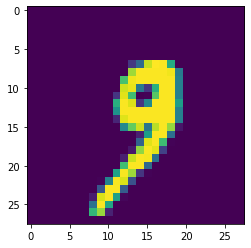

In [37]:
plt.imshow(test_data[1000][0][0])

## 훈련 & 테스트 코드

In [6]:
def train_model(model, device, train_loader, optimizer, n_epochs, fn_loss,
                log_interval=10000):
    model.train()
    for epoch in range(1, n_epochs + 1):
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = fn_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % (log_interval // len(data)) == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                      epoch, batch_idx * len(data), len(train_loader.dataset),
                      100. * batch_idx / len(train_loader), loss.item()))
            
def test_model(model, device, test_loader, fn_loss):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## 예제 1: Linear layer 3개

In [9]:
class ModelV2(torch.nn.Module):
    def __init__(self):
        super(ModelV2, self).__init__()
        self.input_size = 28*28
        self.hidden_size = 256
        self.output_size = 10
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(self.input_size, self.hidden_size),
            torch.nn.Linear(self.hidden_size, self.hidden_size),
            torch.nn.Linear(self.hidden_size, self.output_size),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        for idx, layer in enumerate(self.layers):
            x = layer(x)
            x = F.relu(x) if idx != len(self.layers)-1 else x
        output = F.log_softmax(x, dim=1)
        return output

print("loading ModelV2...") 
model = ModelV2().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
fn_loss = F.nll_loss
print("loaded ModelV2 to {}".format(device))
print(model)
print('Number of model parameters: ', sum(param.numel() for param in model.parameters()))
print("device:", device)
print("lr:", lr)
print("n_epochs:", n_epochs)
print("batch_size:", batch_size)

t = time.perf_counter()
train_model(model, device, train_loader, optimizer, n_epochs, fn_loss, log_interval=60000)
test_model(model, device, test_loader, fn_loss)
print("Train/Eval done. elapsed: {} sec".format(time.perf_counter() - t))

del model
del optimizer
torch.cuda.empty_cache()

loading ModelV2...
loaded ModelV2 to cuda
ModelV2(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)
Number of model parameters:  269322
device: cuda
lr: 0.01
n_epochs: 10
batch_size: 512
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311095
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.720299
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.820058
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.575991
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.486575
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.405163
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.316152
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.375374
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.385419
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.322117

Test set: Average loss: 0.2985, Accuracy: 9141/10000 (91%)

Train/Eval done. elapsed: 89.62024642700001 sec


# Inference TEST

In [20]:
import os
pathModel = './models/mnistModel.pt'
def createFolder(dir):
  try:
    if not os.path.exists(dir):
      os.makedirs(dir)
  except OSerror:
    print("ERROR")
createFolder('./models')
torch.save(ModelV2, './models/mnistModel.pt')

In [22]:
_model = torch.load(pathModel)

def inferenceMnist(input, pred):
  plt.imshow(input)
  plt.imshow(pred)
  test_model(model, device, test_loader, fn_loss)
  plt.imshow(result)
  

In [40]:
val_data = torchvision.datasets.MNIST('./mnist_dataset', train=True, download=True,
                            transform=transform)
x_val, y_val = val_data.data, val_data.targets

TypeError: ignored

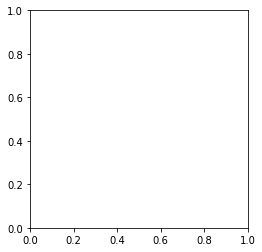

In [42]:
n = 100
x = x_val[n]
y = y_val[n]
plt.imshow(x.numpy()[0])

# use unsqueeze to expand dimensions to 1*C*H*W
x = x.unsqueeze(0)

# convert the type to torch.float32
x = x.type(torch.float)

# move to cuda device
x = x.to(device)

# get the model prediction
output = _model(x)

# get predicted class
pred = output.argmax(dim=1, keepdim=True)
print(pred.item(), y.item())